# EE5175 Lab 10 : Non-local Means Filtering
Author: Kishore Rajendran [EE20B064]

Date: 22 April 2024

In [2]:
# Importing required libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## NLM Filtering
Reference: A non-local algorithm for image denoising (Buades, 2005)

Unlike regular denoising methods like uniform or gaussian kernels which end up blurring the edges as well, we have NLM filtering is able to denoise the image while maintaining its sharpness.

In NLM filtering, we consider a patch of size $(2W_{sim}+1, 2W_{sim}+1)$ around every pixel in the image. We compare this patch with other patches of the same size having their centers at all pixel values in a $(2W+1, 2W+1)$ neighbourhood around the original pixel.

Weights are then assigned to each of these neighbouring patches according to their similarity to the original patch. The denoised estimate is then constructed pixel by pixel using these weights (which is the NLM filter) that varies from pixel to pixel.

In [3]:
def nlm_filtering(g, W, Wsim, sigma_nlm):
    # Normalize and pad the images
    g = g/255
    pad_size = W + Wsim
    pad_g = np.pad(g, ((pad_size,pad_size), (pad_size,pad_size), (0, 0)), mode='constant', constant_values=(0,0))
    fhat = np.zeros_like(pad_g)
    # For every pixel
    for x in range(pad_size, pad_size+g.shape[0]):
        for y in range(pad_size, pad_size+g.shape[1]):
            # Obtain similarity neighbourhood around 'p'
            Np = pad_g[x-Wsim:x+Wsim+1, y-Wsim:y+Wsim+1]
            Vp = Np.reshape(-1, 1)
            # Forming the filter at point 'p'
            wp = np.zeros((2*W+1, 2*W+1))
            for m in range(x-W, x+W+1):
                for n in range(y-W, y+W+1):
                    # Obtain similarity neighbourhood around 'q'
                    Nq = pad_g[m-Wsim:m+Wsim+1, n-Wsim:n+Wsim+1]
                    Vq = Nq.reshape(-1, 1)
                    wp[m+W-x, n+W-y] = np.exp(-((Vp - Vq).T@(Vp - Vq))[0, 0]/sigma_nlm**2)
            # Normalizing the filter
            wp = wp/np.sum(wp)
            wp = wp.reshape(-1, 1)
            # Obtain search neighbourhood RGB patches around 'p'
            NpR = pad_g[x-W:x+W+1, y-W:y+W+1, 0]
            VpR = NpR.reshape(-1, 1)
            NpG = pad_g[x-W:x+W+1, y-W:y+W+1, 1]
            VpG = NpG.reshape(-1, 1)
            NpB = pad_g[x-W:x+W+1, y-W:y+W+1, 2]
            VpB = NpB.reshape(-1, 1)
            # Output pixel intensity at point 'p'
            fhat[x, y, 0] = (VpR.T@wp)[0, 0]
            fhat[x, y, 1] = (VpG.T@wp)[0, 0]
            fhat[x, y, 2] = (VpB.T@wp)[0, 0]
    return (fhat[pad_size:-pad_size, pad_size:-pad_size, :]*255).astype(np.uint8)

## Gaussian Filtering

All the helper functions required to implement gaussian filtering of an image with a fixed size 7x7 kernel and given standard deviation.

In [18]:
# Define 2D convolution operation
def convolve2d(img, kernel):
    conv_img = np.zeros_like(img)
    for c in range(3):
        img_c = img[:,:, c]
        # Flipping the kernel
        flipped_kernel = np.flip(kernel)
        # Pad the image
        kernel_size = kernel.shape[0]
        pad_size = int((kernel_size - 1)/2)
        pad_img_c = np.pad(img_c, ((pad_size,pad_size), (pad_size,pad_size)), mode='constant', constant_values=(0,0))
        # Convolving the padded image and the kernel
        for i in range(img_c.shape[0]):
            for j in range(img_c.shape[1]):
                window = pad_img_c[i:i+kernel_size, j:j+kernel_size]
                conv_img[i, j, c] = np.sum(window*flipped_kernel)
    return conv_img

# A function to generate the values from a 2D gaussian distribution
def gaussian_2d_values(m, n, stdev):
    return (1/(2*np.pi*stdev**2))*np.exp(-(np.square(m) + np.square(n))/(2*stdev**2))

# A function to construct the gaussian blur kernel with a standard size = 7x7
def gaussian_blur_kernel(stdev):
    kernel_size = 7
    # Generating meshgrid s.t center is (0,0)
    offset = (kernel_size - 1)/2
    x = y = np.arange(kernel_size) - offset
    xx, yy = np.meshgrid(x, y)
    # Generate the kernel according to the gaussian distribution values
    kernel = gaussian_2d_values(xx, yy, stdev)
    # Normalizing so that the all values of the kernel sum up to one
    kernel /= np.sum(kernel)
    return kernel

def apply_gaussian_blur(img, stdev):
    # Handling the special case of stdev = 0
    if stdev == 0:
        return img
    # Generating the Gaussian blur kernel
    kernel = gaussian_blur_kernel(stdev)
    # Convolving the image with the blur kernel
    blur_img = convolve2d(img, kernel)
    return blur_img

## PSNR Calculation

PSNR (Peak Signal to Noise Ratio) is a standard metric used to compare the quality of the original and denoised image. The higher the PSNR, the better the denoising effect.

In [4]:
def calculate_PSNR(f, fhat):
    # Normalize the images
    f = f/255
    fhat = fhat/255
    # First flatten f and fhat to column vectors
    f = f.reshape(-1, 1)
    fhat = fhat.reshape(-1, 1)
    tot_pixels = f.shape[0]
    mse = (f-fhat).T@(f-fhat)/tot_pixels
    psnr = 10*np.log10(1/mse)
    return psnr[0, 0]

## Q1, 2: PSNR plots for NLM and Gaussian Filtering

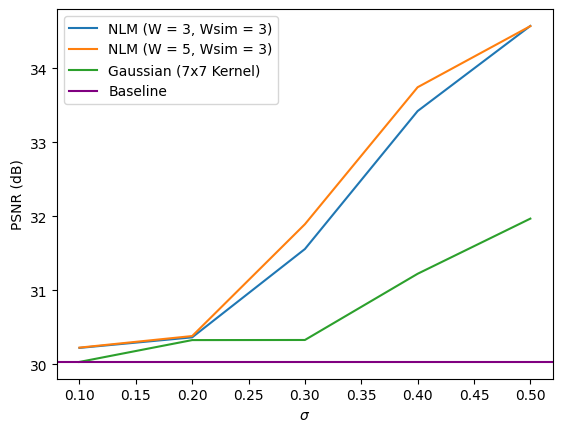

In [26]:
# Importing the image as numpy array
g = np.array(Image.open("krishna_0_001.png"))
f = np.array(Image.open("krishna.png"))

# Baseline PSNR
psnr_base = calculate_PSNR(f, g)

sigma_vals = [0.1, 0.2, 0.3, 0.4, 0.5]
psnr_a = []
psnr_b = []
psnr_g = []

# Calculating all the PSNR values
for sig in sigma_vals:
    fhat_a = nlm_filtering(g, 3, 3, sig)
    psnr_a.append(calculate_PSNR(f, fhat_a))
    fhat_b = nlm_filtering(g, 5, 3, sig)
    psnr_b.append(calculate_PSNR(f, fhat_b))
    fhat_g = apply_gaussian_blur(g, sig)
    psnr_g.append(calculate_PSNR(f, fhat_g))

# Plotting the obtained PSNR values
plt.plot(sigma_vals, psnr_a, label='NLM (W = 3, Wsim = 3)')
plt.plot(sigma_vals, psnr_b, label='NLM (W = 5, Wsim = 3)')
plt.plot(sigma_vals, psnr_g, label='Gaussian (7x7 Kernel)')
plt.axhline(y=psnr_base, label='Baseline', color = 'purple')
plt.legend()
plt.xlabel("$\sigma$")
plt.ylabel("PSNR (dB)")
plt.show()

## Q3, 4: Filter and Image patch visualization

In [34]:
# Defining the two given image pixels
pix1 = np.array([31, 46])
pix2 = np.array([38, 58])

# Modified NLM code to return filter
def return_nlm_filter(g, W, Wsim, sigma_nlm, pix):
    # Normalize and pad the images
    g = g/255
    pad_size = W + Wsim
    pad_g = np.pad(g, ((pad_size,pad_size), (pad_size,pad_size), (0, 0)), mode='constant', constant_values=(0,0))
    fhat = np.zeros_like(pad_g)
    # For the given pixel
    x, y = pix + pad_size
    # Obtain similarity neighbourhood around 'p'
    Np = pad_g[x-Wsim:x+Wsim+1, y-Wsim:y+Wsim+1]
    Vp = Np.reshape(-1, 1)
    # Forming the filter at point 'p'
    wp = np.zeros((2*W+1, 2*W+1))
    for m in range(x-W, x+W+1):
        for n in range(y-W, y+W+1):
            # Obtain similarity neighbourhood around 'q'
            Nq = pad_g[m-Wsim:m+Wsim+1, n-Wsim:n+Wsim+1]
            Vq = Nq.reshape(-1, 1)
            wp[m+W-x, n+W-y] = np.exp(-((Vp - Vq).T@(Vp - Vq))[0, 0]/sigma_nlm**2)
    # Normalizing the filter
    wp = wp/np.sum(wp)
    return wp

### Filter visualization

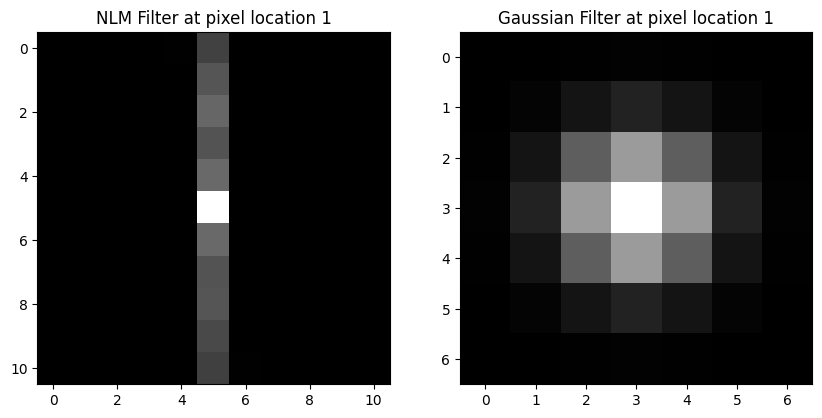

In [42]:
# Obtaining the filters at pixel location 1
filt1_nlm = return_nlm_filter(g, 5, 3, 0.5, pix1)
filt1_g = gaussian_blur_kernel(1)

# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(filt1_nlm, cmap='gray')
ax[0].set_title("NLM Filter at pixel location 1")

ax[1].imshow(filt1_g, cmap='gray')
ax[1].set_title("Gaussian Filter at pixel location 1")

plt.show()

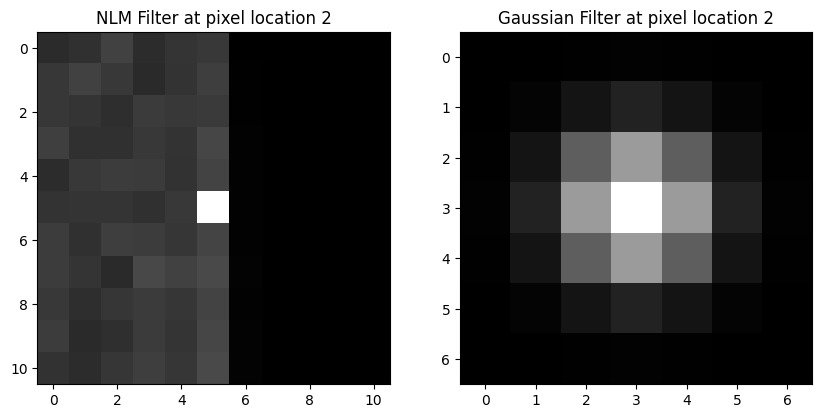

In [41]:
# Obtaining the filters at pixel location 1
filt2_nlm = return_nlm_filter(g, 5, 3, 0.5, pix2)
filt2_g = gaussian_blur_kernel(1)

# Plotting the images side by side
fig, ax = plt.subplots(1, 2, figsize=(10,10))
ax[0].imshow(filt2_nlm, cmap='gray')
ax[0].set_title("NLM Filter at pixel location 2")

ax[1].imshow(filt2_g, cmap='gray')
ax[1].set_title("Gaussian Filter at pixel location 2")

plt.show()

### Image patch visualization

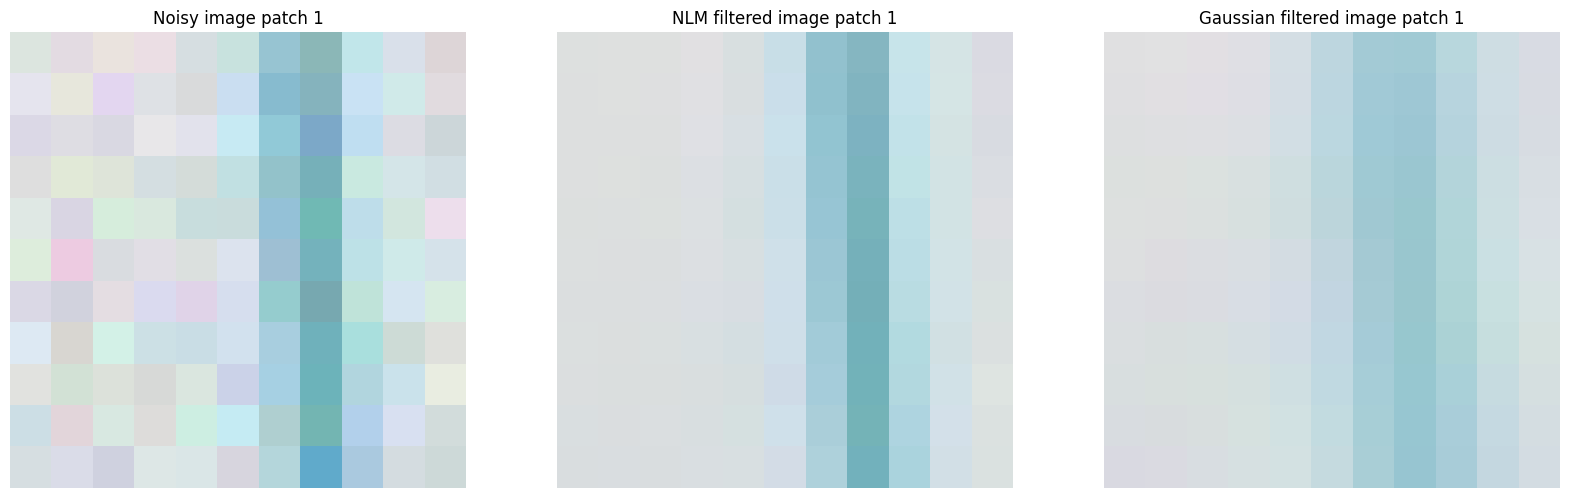

In [39]:
# Generating the required denoised images for visualization purposes
img_a = nlm_filtering(g, 5, 3, 0.5)
img_b = apply_gaussian_blur(g, 1)

# Obtaining the required patches at pixel location 1
noisy_patch1 = g[pix1[0]-5:pix1[0]+6, pix1[1]-5:pix1[1]+6,:]
nlm_patch1 = img_a[pix1[0]-5:pix1[0]+6, pix1[1]-5:pix1[1]+6,:]
gaussian_patch1 = img_b[pix1[0]-5:pix1[0]+6, pix1[1]-5:pix1[1]+6,:]

# Plotting the images side by side
fig, ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(noisy_patch1, cmap='gray')
ax[0].set_title("Noisy image patch 1")
ax[0].axis('off')

ax[1].imshow(nlm_patch1, cmap='gray')
ax[1].set_title("NLM filtered image patch 1")
ax[1].axis('off')

ax[2].imshow(gaussian_patch1, cmap='gray')
ax[2].set_title("Gaussian filtered image patch 1")
ax[2].axis('off')

plt.show()

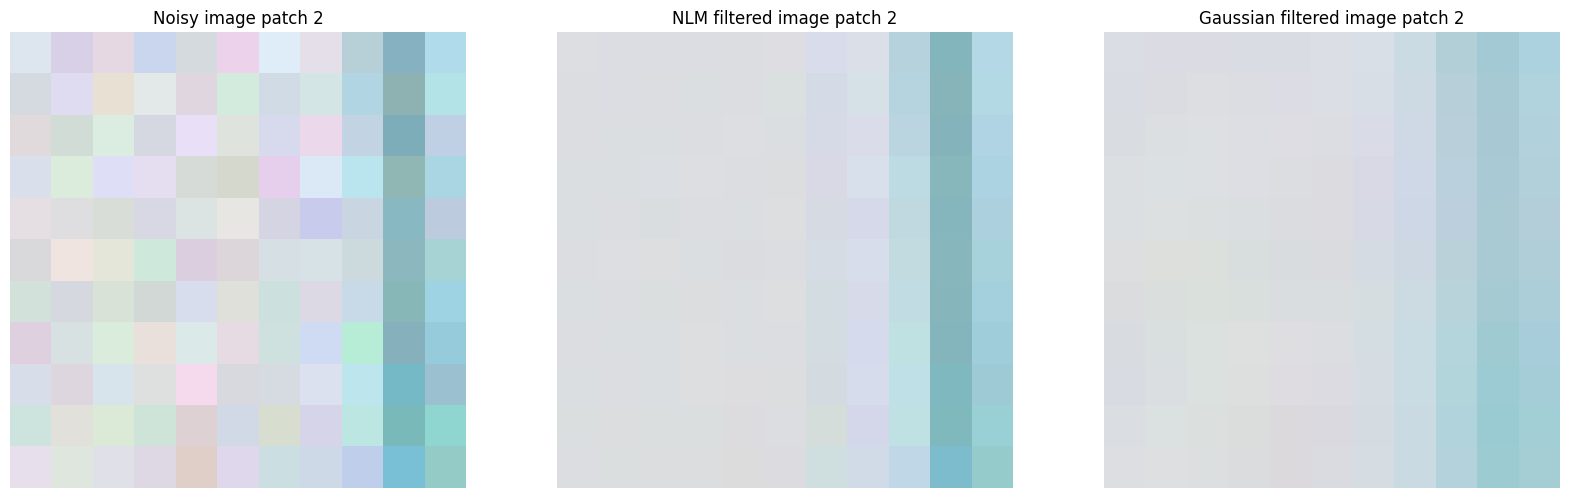

In [40]:
# Obtaining the required patches at pixel location 1
noisy_patch2 = g[pix2[0]-5:pix2[0]+6, pix2[1]-5:pix2[1]+6,:]
nlm_patch2 = img_a[pix2[0]-5:pix2[0]+6, pix2[1]-5:pix2[1]+6,:]
gaussian_patch2 = img_b[pix2[0]-5:pix2[0]+6, pix2[1]-5:pix2[1]+6,:]

# Plotting the images side by side
fig, ax = plt.subplots(1, 3, figsize=(20,20))
ax[0].imshow(noisy_patch2, cmap='gray')
ax[0].set_title("Noisy image patch 2")
ax[0].axis('off')

ax[1].imshow(nlm_patch2, cmap='gray')
ax[1].set_title("NLM filtered image patch 2")
ax[1].axis('off')

ax[2].imshow(gaussian_patch2, cmap='gray')
ax[2].set_title("Gaussian filtered image patch 2")
ax[2].axis('off')

plt.show()

# Observations
1. The PSNR plots vs standard deviation show that for the given range of $\sigma$ values, the denoising performance increases for all 3 methods with increasing $\sigma$ and all are better than the baseline PSNR between the original and noisy image.
2. Clearly, the NLM methods are much better than the Gaussian filtering method, since their PSNR plots lie much above the Gaussian one.
3. There isn't a huge difference between the cases where W=3 or W=5, but as expected the greater value of W (search window) gives slightly better performance.
4. The filters at the 2 different locations are very different for NLM as expected and are the same for the Gaussian case (space invariant blurring).
5. The image patches clearly show how great NLM is at filtering, as it is able to denoise the noisy image and also retain the sharp edges unlike the gaussian method which smoothes it over.
6. NLM filtering is able to denoise images effectively but it is a very computationally expensive method compared to other standard filtering approaches.